In [1]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from scipy.stats import linregress

# Netflix Media Counts by Happiness Index

In [2]:
# File to Load Netflix Metacritic Data
file_to_load = 'Data Sets/Latest Netflix data with 26+ joined attributes/netflix-rotten-tomatoes-metacritic-imdb.csv'
netflix_metacritic = pd.read_csv(file_to_load)

# File to Load Happiness Report Data
file_to_load_h = 'Data Sets/World Happiness Report/world-happiness-report-2021.csv'
world_happiness_report = pd.read_csv(file_to_load_h)

world_happiness_report.head()
world_happiness_report_sub = world_happiness_report[['Country name','Regional indicator','Ladder score']]
world_happiness_report_sub.columns = ['Country','Region','Ladder Score']
world_happiness_report_sub

,Country,Region,Ladder Score
0,Finland,Western Europe,7.842
1,Denmark,Western Europe,7.620
2,Switzerland,Western Europe,7.571
3,Iceland,Western Europe,7.554
4,Netherlands,Western Europe,7.464
...,...,...,...
144,Lesotho,Sub-Saharan Africa,3.512
145,Botswana,Sub-Saharan Africa,3.467
146,Rwanda,Sub-Saharan Africa,3.415
147,Zimbabwe,Sub-Saharan Africa,3.145


In [3]:
# Create a subset of netflix metacritic data to include only necessary data
netflix_metacritic.head()
netflix_metacritic_subset = netflix_metacritic[['Title','Genre','Languages','Country Availability','Director', 'Series or Movie']]
netflix_metacritic_subset.columns = ['Title','Genre','Languages','Country','Director','Series or Movie']

# Explode country availability column into rows and create a dataframe
netflix_country_split = netflix_metacritic_subset.Country.str.split(',')
series = netflix_country_split.apply(pd.Series, 1)
stacked = series.stack()
drop = stacked.index = stacked.index.droplevel(-1)
df = pd.DataFrame(stacked)
df = df.join(netflix_metacritic_subset)
del df['Country']
df.columns = ['Country','Title','Genre','Languages','Director','Media Type']
df = df.reset_index(drop=True)
df.to_csv('Data Sets/G3_Netflix_by_Country.csv', index = False)
df

,Country,Title,Genre,Languages,Director,Media Type
0,Thailand,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Swedish, Spanish",Tomas Alfredson,Series
1,Canada,HOW TO BUILD A GIRL,Comedy,English,Coky Giedroyc,Movie
2,Canada,Centigrade,"Drama, Thriller",English,Brendan Walsh,Movie
3,Belgium,ANNE+,Drama,Turkish,NaN,Series
4,Netherlands,ANNE+,Drama,Turkish,NaN,Series
...,...,...,...,...,...,...
195580,Brazil,DreamWorks Kung Fu Panda Awesome Secrets,"Animation, Action, Comedy, Family",English,NaN,Series
195581,Netherlands,DreamWorks Kung Fu Panda Awesome Secrets,"Animation, Action, Comedy, Family",English,NaN,Series
195582,Italy,DreamWorks Kung Fu Panda Awesome Secrets,"Animation, Action, Comedy, Family",English,NaN,Series
195583,Israel,DreamWorks Kung Fu Panda Awesome Secrets,"Animation, Action, Comedy, Family",English,NaN,Series


In [4]:
# create a dataframe containing media type counts by country
media_bycountry = df.groupby(['Country','Media Type'])['Title'].nunique()
media_bycountry = pd.DataFrame(media_bycountry)
media_bycountry = media_bycountry.reset_index()
media_bycountry

,Country,Media Type,Title
0,Argentina,Movie,3356
1,Argentina,Series,1754
2,Australia,Movie,3721
3,Australia,Series,2066
4,Belgium,Movie,3580
...,...,...,...
67,Turkey,Series,1737
68,United Kingdom,Movie,4102
69,United Kingdom,Series,2171
70,United States,Movie,3633


In [5]:
# create a dataframe that merges netflix data with happiness score by country
happynetflix_merge = pd.merge(media_bycountry, world_happiness_report_sub, on='Country',how='inner')
happynetflix_merge.columns = ['Country','Media Type','Media Count','Region','Happiness Score']
happynetflix_merge = happynetflix_merge[['Region','Country','Happiness Score','Media Type','Media Count']]
happynetflix_merge

,Region,Country,Happiness Score,Media Type,Media Count
0,Latin America and Caribbean,Argentina,5.929,Movie,3356
1,Latin America and Caribbean,Argentina,5.929,Series,1754
2,North America and ANZ,Australia,7.183,Movie,3721
3,North America and ANZ,Australia,7.183,Series,2066
4,Western Europe,Belgium,6.834,Movie,3580
...,...,...,...,...,...
65,Middle East and North Africa,Turkey,4.948,Series,1737
66,Western Europe,United Kingdom,7.064,Movie,4102
67,Western Europe,United Kingdom,7.064,Series,2171
68,North America and ANZ,United States,6.951,Movie,3633


In [6]:
# create a subset of netflix data for movies only
media_bycountry = happynetflix_merge[['Country','Happiness Score','Media Type','Media Count']]
movies_bycountry = media_bycountry[media_bycountry['Media Type'] == 'Movie']
movies_byhappy = pd.merge(movies_bycountry,world_happiness_report_sub,on=['Country'], how='outer')
movies_byhappy = movies_byhappy.drop('Happiness Score', axis=1)
movies_byhappy.columns = ['Country','Media Type','Media Count','Region','Happiness Score']
movies_byhappy = movies_byhappy.sort_values('Happiness Score', ascending = False)
movies_byhappy

# create a subset of netflix data for tv shows only
tv_bycountry = media_bycountry[media_bycountry['Media Type'] == 'Series']
tv_byhappy = pd.merge(tv_bycountry,world_happiness_report_sub,on=['Country'], how='outer')
tv_byhappy = tv_byhappy.drop('Happiness Score', axis=1)
tv_byhappy.columns = ['Country','Media Type','Media Count','Region','Happiness Score']
tv_byhappy = tv_byhappy.sort_values('Happiness Score', ascending = False)
tv_byhappy

,Country,Media Type,Media Count,Region,Happiness Score
35,Finland,NaN,NaN,Western Europe,7.842
36,Denmark,NaN,NaN,Western Europe,7.620
30,Switzerland,Series,1932.0,Western Europe,7.571
11,Iceland,Series,1944.0,Western Europe,7.554
19,Netherlands,Series,1753.0,Western Europe,7.464
...,...,...,...,...,...
144,Lesotho,NaN,NaN,Sub-Saharan Africa,3.512
145,Botswana,NaN,NaN,Sub-Saharan Africa,3.467
146,Rwanda,NaN,NaN,Sub-Saharan Africa,3.415
147,Zimbabwe,NaN,NaN,Sub-Saharan Africa,3.145


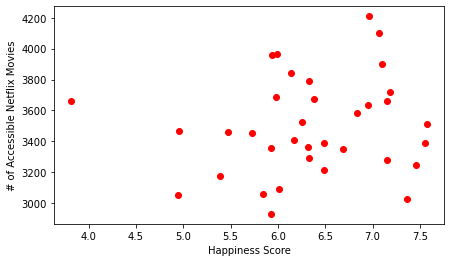

In [7]:
# select x and y values for plotting
y_values = movies_byhappy['Media Count']
x_values = movies_byhappy['Happiness Score']

# create scatter plot of accessible netflix movies by happiness score
fig = plt.subplots(figsize=(7,4))
plt.rc('font', size=12) 
movie_plot = plt.scatter(x_values,y_values,c='red')

# format labels properly
plt.ylabel('# of Accessible Netflix Movies')
plt.xlabel('Happiness Score')

plt.savefig('Images/Movies_byHappinessScore.png')

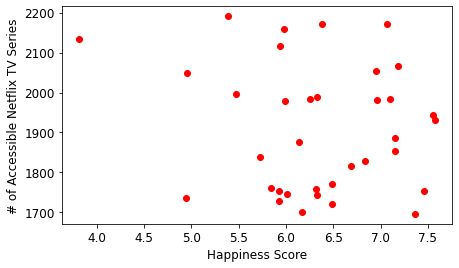

In [8]:
# select x and y values for plotting
y_values = tv_byhappy['Media Count']
x_values = tv_byhappy['Happiness Score']

# create scatter plot of accessible netflix tv series by happiness score
fig = plt.subplots(figsize=(7,4))
plt.rc('font', size=12)
plt.scatter(x_values,y_values, c='red')

# format labels properly
plt.ylabel('# of Accessible Netflix TV Series')
plt.xlabel('Happiness Score')

plt.savefig('Images/TVSeries_byHappinessScore.png')

# Netflix Revenue and Subscribers's merge

In [9]:
# File to Load 
file_to_load_two = 'Data Sets/Netflix Subscribers and Revenue by Country/DataNetflixRevenue2020_V2.csv'
netflix_subscribers_country= pd.read_csv(file_to_load_two)

In [10]:
netflix_subscribers_country.head()
netflix_rev_region = netflix_subscribers_country.groupby(['Area','Years']).sum('Subscribers')
netflix_rev_region

Revenue
Area                            Years                
Asia-Pacific                    Q1 - 2018   199117000
                                Q1 - 2019   319602000
                                Q1 - 2020   483660000
                                Q2 - 2018   221252000
                                Q2 - 2019   349494000
                                Q2 - 2020   569140000
                                Q3 - 2018   248691000
                                Q3 - 2019   382304000
                                Q4 - 2018   276756000
                                Q4 - 2019   418121000
Europe,  Middle East and Africa Q1 - 2018   886649000
                                Q1 - 2019  1233379000
                                Q1 - 2020  1723474000
                                Q2 - 2018   975497000
                                Q2 - 2019  1319087000
                                Q2 - 2020  1892537000
                                Q3 - 2018  1004749000
                                Q3 - 2019  1428040000
                                Q4 - 2018  1096812000
                                Q4 - 2019  1562561000
Latin America                   Q1 - 2018   540182000
                                Q1 - 2019   630472000
                                Q1 - 2020   793453000
                                Q2 - 2018   568071000
                                Q2 - 2019   677136000
                                Q2 - 2020   785368000
                                Q3 - 2018   562307000
                                Q3 - 2019   741434000
                                Q4 - 2018   567137000
                                Q4 - 2019   746392000
United States and Canada        Q1 - 2018  1976157000
                                Q1 - 2019  2256851000
                                Q1 - 2020  2702776000
                                Q2 - 2018  2049546000
                                Q2 - 2019  2501199000
                                Q2 - 2020  2839670000
                                Q3 - 2018  2094850000
                                Q3 - 2019  2621250000
                                Q4 - 2018  2160979000
                                Q4 - 2019  2671908000

In [11]:
# File to Load 
file_to_load_three = 'Data Sets/Netflix Subscribers and Revenue by Country/DataNetflixSubscriber2020_V2.csv'
netflix_subscribers_revenue = pd.read_csv(file_to_load_three)

In [12]:
# Netflix Subscribers groupby
netflix_subscribers_revenue.head()
netflix_subs_region = netflix_subscribers_revenue.groupby(['Area','Years']).sum('Subscribers')
netflix_subs_region

Subscribers
Area                            Years                 
Asia-Pacific                    Q1 - 2018      7394000
                                Q1 - 2019     12141000
                                Q1 - 2020     19835000
                                Q2 - 2018      8372000
                                Q2 - 2019     12942000
                                Q2 - 2020     22492000
                                Q3 - 2018      9461000
                                Q3 - 2019     14485000
                                Q4 - 2018     10607000
                                Q4 - 2019     16233000
Europe,  Middle East and Africa Q1 - 2018     29339000
                                Q1 - 2019     42542000
                                Q1 - 2020     58734000
                                Q2 - 2018     31317000
                                Q2 - 2019     44229000
                                Q2 - 2020     61483000
                                Q3 - 2018     33836000
                                Q3 - 2019     47355000
                                Q4 - 2018     37818000
                                Q4 - 2019     51778000
Latin America                   Q1 - 2018     21260000
                                Q1 - 2019     27547000
                                Q1 - 2020     34318000
                                Q2 - 2018     22795000
                                Q2 - 2019     27890000
                                Q2 - 2020     36068000
                                Q3 - 2018     24115000
                                Q3 - 2019     29380000
                                Q4 - 2018     26077000
                                Q4 - 2019     31417000
United States and Canada        Q1 - 2018     60909000
                                Q1 - 2019     66633000
                                Q1 - 2020     69969000
                                Q2 - 2018     61870000
                                Q2 - 2019     66501000
                                Q2 - 2020     72904000
                                Q3 - 2018     63010000
                                Q3 - 2019     67114000
                                Q4 - 2018     64757000
                                Q4 - 2019     67662000

In [13]:
# Creating a list and filling it with 0
clean_df = [0]*40
# Merging Revenue and Subscribers and adding a column and a list
merge_data = pd.merge(netflix_subscribers_country,netflix_subscribers_revenue, on=['Years', 'Area'])
merge_data['Edit'] = clean_df
merge_data.head()

,Area,Years,Revenue,Subscribers,Edit
0,United States and Canada,Q1 - 2018,1976157000,60909000,0
1,"Europe, Middle East and Africa",Q1 - 2018,886649000,29339000,0
2,Latin America,Q1 - 2018,540182000,21260000,0
3,Asia-Pacific,Q1 - 2018,199117000,7394000,0
4,United States and Canada,Q2 - 2018,2049546000,61870000,0


In [14]:
# Revenue and Subscribers groupby and deleting Edit column
netflix_rev_subs_region_goupby = merge_data.groupby(['Area','Years']).sum('Edit')
netflix_rev_subs_region_goupby.drop(['Edit'], axis = 1, inplace = True)
netflix_rev_subs_region_goupby

Revenue  Subscribers
Area                            Years                             
Asia-Pacific                    Q1 - 2018   199117000      7394000
                                Q1 - 2019   319602000     12141000
                                Q1 - 2020   483660000     19835000
                                Q2 - 2018   221252000      8372000
                                Q2 - 2019   349494000     12942000
                                Q2 - 2020   569140000     22492000
                                Q3 - 2018   248691000      9461000
                                Q3 - 2019   382304000     14485000
                                Q4 - 2018   276756000     10607000
                                Q4 - 2019   418121000     16233000
Europe,  Middle East and Africa Q1 - 2018   886649000     29339000
                                Q1 - 2019  1233379000     42542000
                                Q1 - 2020  1723474000     58734000
                                Q2 - 2018   975497000     31317000
                                Q2 - 2019  1319087000     44229000
                                Q2 - 2020  1892537000     61483000
                                Q3 - 2018  1004749000     33836000
                                Q3 - 2019  1428040000     47355000
                                Q4 - 2018  1096812000     37818000
                                Q4 - 2019  1562561000     51778000
Latin America                   Q1 - 2018   540182000     21260000
                                Q1 - 2019   630472000     27547000
                                Q1 - 2020   793453000     34318000
                                Q2 - 2018   568071000     22795000
                                Q2 - 2019   677136000     27890000
                                Q2 - 2020   785368000     36068000
                                Q3 - 2018   562307000     24115000
                                Q3 - 2019   741434000     29380000
                                Q4 - 2018   567137000     26077000
                                Q4 - 2019   746392000     31417000
United States and Canada        Q1 - 2018  1976157000     60909000
                                Q1 - 2019  2256851000     66633000
                                Q1 - 2020  2702776000     69969000
                                Q2 - 2018  2049546000     61870000
                                Q2 - 2019  2501199000     66501000
                                Q2 - 2020  2839670000     72904000
                                Q3 - 2018  2094850000     63010000
                                Q3 - 2019  2621250000     67114000
                                Q4 - 2018  2160979000     64757000
                                Q4 - 2019  2671908000     67662000

# World Happiness Report

In [15]:
# File to Load 
file_to_load_h = 'Data Sets/World Happiness Report/world-happiness-report-2021.csv'
world_happiness_report = pd.read_csv(file_to_load_h)

In [16]:
# Narrowing World Happiness Report
world_happiness_report.head()
world_happiness_report_sub = world_happiness_report[['Country name','Regional indicator','Ladder score','Logged GDP per capita']]
world_happiness_report_sub.columns = ['Country','Region','Ladder Score','Logged GDP per capita']
world_happiness_report_sub

,Country,Region,Ladder Score,Logged GDP per capita
0,Finland,Western Europe,7.842,10.775
1,Denmark,Western Europe,7.620,10.933
2,Switzerland,Western Europe,7.571,11.117
3,Iceland,Western Europe,7.554,10.878
4,Netherlands,Western Europe,7.464,10.932
...,...,...,...,...
144,Lesotho,Sub-Saharan Africa,3.512,7.926
145,Botswana,Sub-Saharan Africa,3.467,9.782
146,Rwanda,Sub-Saharan Africa,3.415,7.676
147,Zimbabwe,Sub-Saharan Africa,3.145,7.943


In [17]:
# File to Load 
file_to_load_h = 'Data Sets/World Information/continents2.csv'
country_df = pd.read_csv(file_to_load_h)

In [18]:
# Merging World Happiness Report and Country Regions by column
world_happiness_report_sub = pd.merge(left = world_happiness_report_sub, right = country_df, how = 'left', left_on= 'Country', right_on = 'name')

In [19]:
# Dropping Columns in merged DataFrame
world_happiness_report_sub.drop(['alpha-2', 'alpha-3', 'country-code', 'iso_3166-2', 'region-code', 'sub-region-code', 'intermediate-region-code','name'], axis = 1, inplace = True)

In [20]:
# Adding the column 'Area'
world_happiness_report_sub['Area']= ''
# Measudint the length of World Happiness Report
len(world_happiness_report_sub)

149

In [21]:
world_happiness_report_sub

,Country,Region,Ladder Score,Logged GDP per capita,region,sub-region,intermediate-region,Area
0,Finland,Western Europe,7.842,10.775,Europe,Northern Europe,NaN,
1,Denmark,Western Europe,7.620,10.933,Europe,Northern Europe,NaN,
2,Switzerland,Western Europe,7.571,11.117,Europe,Western Europe,NaN,
3,Iceland,Western Europe,7.554,10.878,Europe,Northern Europe,NaN,
4,Netherlands,Western Europe,7.464,10.932,Europe,Western Europe,NaN,
...,...,...,...,...,...,...,...,...
144,Lesotho,Sub-Saharan Africa,3.512,7.926,Africa,Sub-Saharan Africa,Southern Africa,
145,Botswana,Sub-Saharan Africa,3.467,9.782,Africa,Sub-Saharan Africa,Southern Africa,
146,Rwanda,Sub-Saharan Africa,3.415,7.676,Africa,Sub-Saharan Africa,Eastern Africa,
147,Zimbabwe,Sub-Saharan Africa,3.145,7.943,Africa,Sub-Saharan Africa,Eastern Africa,


In [22]:
# Conditional for 'Area' using the Regions by ISO 3166-2
area = []
for c in world_happiness_report_sub['Region']:
    if c == 'Western Europe':
        area.append('Europe, Middle East and Africa')
    elif c == 'Central and Eastern Europe':
            area.append('Europe, Middle East and Africa')    
    elif c == 'Middle East and North Africa':
            area.append('Europe, Middle East and Africa')
    elif c == 'Sub-Saharan Africa':
            area.append('Europe, Middle East and Africa')
    elif c == 'East Asia':
            area.append('Asia-Pacific')    
    elif c == 'Southeast Asia':
            area.append('Asia-Pacific')
    elif c == 'South Asia':
            area.append('Asia-Pacific')
    elif c == 'Latin America and Caribbean':
            area.append('Latin America')
    else:
        area.append('NaN')

In [23]:
len(area)

149

In [24]:
# Adding area list to the 'Area column'
world_happiness_report_sub['Area'] = area

In [25]:
# Filling Nan
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'New Zealand', 'Area'] = 'Asia-Pacific'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'Australia', 'Area'] = 'Asia-Pacific'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'United States', 'Area'] = 'United States and Canada'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'Canada', 'Area'] = 'United States and Canada'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'Uzbekistan', 'Area'] = 'Asia-Pacific'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'Kazakhstan', 'Area'] = 'Asia-Pacific'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'Moldova', 'Area'] = 'Europe, Middle East and Africa'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'Kyrgyzstan', 'Area'] = 'Asia-Pacific'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'Belarus', 'Area'] = 'Europe, Middle East and Africa'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'Russia', 'Area'] = 'Europe, Middle East and Africa'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'Tajikistan', 'Area'] = 'Asia-Pacific'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'Azerbaijan', 'Area'] = 'Asia-Pacific'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'Armenia', 'Area'] = 'Asia-Pacific'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'Turkmenistan', 'Area'] = 'Asia-Pacific'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'Georgia', 'Area'] = 'Asia-Pacific'
world_happiness_report_sub.loc[world_happiness_report_sub['Country'] == 'Ukraine', 'Area'] = 'Europe, Middle East and Africa'

In [26]:
# World Happyness groupby by Area
world_happiness_report_sub_groupby = world_happiness_report_sub.groupby('Area').mean('Ladder score')
world_happiness_report_sub_groupby

,Ladder Score,Logged GDP per capita
Area,,
Asia-Pacific,5.407344,9.472063
"Europe, Middle East and Africa",5.464663,9.400989
Latin America,5.908050,9.370000
United States and Canada,7.027000,10.899500


In [27]:
# Bug fixing
# world_happiness_report_sub_groupby.drop(['country-code', 'region-code', 'sub-region-code', 'intermediate-region-code'], axis = 1, inplace = True)

# World Happiness Report by year

In [28]:
# File to Load 
file_to_load_r = 'Data Sets/World Happiness Report/world-happiness-report.csv'
world_happiness= pd.read_csv(file_to_load_r)
len(world_happiness)

1949

In [29]:
# Deleting years before 2018
#world_happiness.drop(world_happiness.index[(world_happiness["year"] == "2008")],axis=0,inplace=True)
# world_happiness_report_t  = world_happiness_report_t[world_happiness_report_t.year != '2008']
world_happiness.drop(world_happiness[world_happiness['year'] < 2018].index, inplace = True)

In [30]:
world_happiness

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
10,Afghanistan,2018,2.694,7.692,0.508,52.6,0.374,-0.094,0.928,0.424,0.405
11,Afghanistan,2019,2.375,7.697,0.420,52.4,0.394,-0.108,0.924,0.351,0.502
22,Albania,2018,5.004,9.518,0.684,68.7,0.824,0.009,0.899,0.713,0.319
23,Albania,2019,4.995,9.544,0.686,69.0,0.777,-0.099,0.914,0.681,0.274
24,Albania,2020,5.365,9.497,0.710,69.3,0.754,0.007,0.891,0.679,0.265
...,...,...,...,...,...,...,...,...,...,...,...
1932,Zambia,2019,3.307,8.155,0.638,55.8,0.811,0.077,0.832,0.743,0.394
1933,Zambia,2020,4.838,8.117,0.767,56.3,0.750,0.056,0.810,0.691,0.345
1946,Zimbabwe,2018,3.616,8.049,0.775,55.6,0.763,-0.068,0.844,0.710,0.212
1947,Zimbabwe,2019,2.694,7.950,0.759,56.2,0.632,-0.064,0.831,0.716,0.235


In [31]:
# Deleting columns on World Happiness Report 
world_happiness.drop(['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect'], axis = 1, inplace = True)

In [32]:
# Merge reports 
world_happiness = pd.merge(left = world_happiness, right = world_happiness_report_sub, how = 'left', left_on= 'Country name', right_on = 'Country')

In [33]:
#Filling Nan
world_happiness.loc[world_happiness['Country name'] == 'Angola', 'Area'] = 'Europe, Middle East and Africa'
world_happiness.loc[world_happiness['Country name'] == 'Belize', 'Area'] = 'Latin America'
world_happiness.loc[world_happiness['Country name'] == 'Bhutan', 'Area'] = 'Asia-Pacific'
world_happiness.loc[world_happiness['Country name'] == 'Congo (Kinshasa)', 'Area'] = 'Europe, Middle East and Africa'
world_happiness.loc[world_happiness['Country name'] == 'Cuba', 'Area'] = 'Latin America'
world_happiness.loc[world_happiness['Country name'] == 'Djibouti', 'Area'] = 'Europe, Middle East and Africa'
world_happiness.loc[world_happiness['Country name'] == 'Oman', 'Area'] = 'Europe, Middle East and Africa'
world_happiness.loc[world_happiness['Country name'] == 'Guyana', 'Area'] = 'Latin America'
world_happiness.loc[world_happiness['Country name'] == 'Qatar', 'Area'] = 'Asia-Pacific'
world_happiness.loc[world_happiness['Country name'] == 'Somalia', 'Area'] = 'Europe, Middle East and Africa'
world_happiness.loc[world_happiness['Country name'] == 'South Sudan', 'Area'] = 'Europe, Middle East and Africa'
world_happiness.loc[world_happiness['Country name'] == 'Sudan', 'Area'] = 'Europe, Middle East and Africa'
world_happiness.loc[world_happiness['Country name'] == 'Suriname', 'Area'] = 'Latin America'
world_happiness.loc[world_happiness['Country name'] == 'Syria', 'Area'] = 'Asia-Pacific'
world_happiness.loc[world_happiness['Country name'] == 'Trinidad and Tobago', 'Area'] = 'Latin America'

In [34]:
# Dropping columns
world_happiness.drop(['Country','sub-region','Region', 'Ladder Score', 'region', 'intermediate-region'], axis = 1, inplace = True)

In [35]:
# Renaming columns
world_happiness.rename(columns={'Country name':'Country'}, inplace=True)
world_happiness.rename(columns={'year':'Years'}, inplace=True)
world_happiness

,Country,Years,Life Ladder,Logged GDP per capita,Area
0,Afghanistan,2018,2.694,7.695,Asia-Pacific
1,Afghanistan,2019,2.375,7.695,Asia-Pacific
2,Albania,2018,5.004,9.520,"Europe, Middle East and Africa"
3,Albania,2019,4.995,9.520,"Europe, Middle East and Africa"
4,Albania,2020,5.365,9.520,"Europe, Middle East and Africa"
...,...,...,...,...,...
376,Zambia,2019,3.307,8.145,"Europe, Middle East and Africa"
377,Zambia,2020,4.838,8.145,"Europe, Middle East and Africa"
378,Zimbabwe,2018,3.616,7.943,"Europe, Middle East and Africa"
379,Zimbabwe,2019,2.694,7.943,"Europe, Middle East and Africa"


In [36]:
# World Happiness groupby Life Ladder's mean
world_happiness_gb = world_happiness.groupby(['Area','Years']).mean('Life Ladder')
world_happiness_gb

Life Ladder  Logged GDP per capita
Area                           Years                                    
Asia-Pacific                   2018      5.335806               9.422774
                               2019      5.423774               9.460645
                               2020      5.663632               9.576421
Europe, Middle East and Africa 2018      5.432220               9.371473
                               2019      5.475880               9.420250
                               2020      5.887825               9.885159
Latin America                  2018      5.951167               9.375889
                               2019      6.117579               9.469632
                               2020      5.660182               9.570909
United States and Canada       2018      7.029000              10.899500
                               2019      7.026500              10.899500
                               2020      7.026500              10.899500

In [37]:
# # # # Verifiying Output
# world_happiness.to_csv('/Users/karlaflores/Desktop/List.csv', index=True, header=True)

# Netflix Revenue and Subscribers by year

In [38]:
# Revenue and Subscribers's merge
merge_data.head()

,Area,Years,Revenue,Subscribers,Edit
0,United States and Canada,Q1 - 2018,1976157000,60909000,0
1,"Europe, Middle East and Africa",Q1 - 2018,886649000,29339000,0
2,Latin America,Q1 - 2018,540182000,21260000,0
3,Asia-Pacific,Q1 - 2018,199117000,7394000,0
4,United States and Canada,Q2 - 2018,2049546000,61870000,0


In [39]:
# Deleting Q1, Q2, Q3, Q4
merge_data = merge_data[merge_data.Years != 'Q1 - 2018']
merge_data = merge_data[merge_data.Years != 'Q2 - 2018']
merge_data = merge_data[merge_data.Years != 'Q3 - 2018']
merge_data = merge_data[merge_data.Years != 'Q1 - 2019']
merge_data = merge_data[merge_data.Years != 'Q2 - 2019']
merge_data = merge_data[merge_data.Years != 'Q3 - 2019']
merge_data = merge_data[merge_data.Years != 'Q1 - 2020']

In [40]:
# Spliting column year
netflix_rev_region_year = merge_data
netflix_rev_region_year[['Quarter','Year']] = netflix_rev_region_year.Years.str.split("-", expand=True)
netflix_rev_region_year.drop(['Years', 'Quarter'], axis = 1, inplace = True)
column_names = ['Area', 'Year', 'Revenue', 'Subscribers', 'Edit']
netflix_rev_region_year = netflix_rev_region_year.reindex(columns=column_names)
netflix_rev_region_year.rename(columns={'Year':'Years'}, inplace=True)

In [41]:
netflix_rev_region_year

,Area,Years,Revenue,Subscribers,Edit
12,United States and Canada,2018,2160979000,64757000,0
13,"Europe, Middle East and Africa",2018,1096812000,37818000,0
14,Latin America,2018,567137000,26077000,0
15,Asia-Pacific,2018,276756000,10607000,0
28,United States and Canada,2019,2671908000,67662000,0
29,"Europe, Middle East and Africa",2019,1562561000,51778000,0
30,Latin America,2019,746392000,31417000,0
31,Asia-Pacific,2019,418121000,16233000,0
36,United States and Canada,2020,2839670000,72904000,0
37,"Europe, Middle East and Africa",2020,1892537000,61483000,0


In [42]:
# Merging Revenue and Subscribers with World Happiness by year
w_happiness_netflix_sr = pd.merge(left = netflix_rev_region_year, right = world_happiness, how = 'left', left_on=['Area'], right_on = ['Area'])
w_happiness_netflix_sr.head()

,Area,Years_x,Revenue,Subscribers,Edit,Country,Years_y,Life Ladder,Logged GDP per capita
0,United States and Canada,2018,2160979000,64757000,0,Canada,2018.0,7.175,10.776
1,United States and Canada,2018,2160979000,64757000,0,Canada,2019.0,7.109,10.776
2,United States and Canada,2018,2160979000,64757000,0,Canada,2020.0,7.025,10.776
3,United States and Canada,2018,2160979000,64757000,0,United States,2018.0,6.883,11.023
4,United States and Canada,2018,2160979000,64757000,0,United States,2019.0,6.944,11.023


In [43]:
# Modifying Edit column edit list and groupby dataframe
netflix_rev_region_year_goupby = netflix_rev_region_year.groupby(['Area','Years']).sum('Edit')
edit = [5.335806, 5.423774, 5.663632, 5.432220, 5.475880, 5.887825, 5.951167, 6.117579, 5.660182, 7.029000, 7.026500, 7.026500]
netflix_rev_region_year_goupby['Edit'] = edit
netflix_rev_region_year_goupby.rename(columns={'Edit':'Life Ladder'}, inplace=True)
netflix_rev_region_year_goupby

Revenue  Subscribers  Life Ladder
Area                            Years                                      
Asia-Pacific                     2018   276756000     10607000     5.335806
                                 2019   418121000     16233000     5.423774
                                 2020   569140000     22492000     5.663632
Europe,  Middle East and Africa  2018  1096812000     37818000     5.432220
                                 2019  1562561000     51778000     5.475880
                                 2020  1892537000     61483000     5.887825
Latin America                    2018   567137000     26077000     5.951167
                                 2019   746392000     31417000     6.117579
                                 2020   785368000     36068000     5.660182
United States and Canada         2018  2160979000     64757000     7.029000
                                 2019  2671908000     67662000     7.026500
                                 2020  2839670000     72904000     7.026500

In [44]:
# Reseting index
reset_index = netflix_rev_region_year_goupby.reset_index()
reset_index

,Area,Years,Revenue,Subscribers,Life Ladder
0,Asia-Pacific,2018,276756000,10607000,5.335806
1,Asia-Pacific,2019,418121000,16233000,5.423774
2,Asia-Pacific,2020,569140000,22492000,5.663632
3,"Europe, Middle East and Africa",2018,1096812000,37818000,5.432220
4,"Europe, Middle East and Africa",2019,1562561000,51778000,5.475880
5,"Europe, Middle East and Africa",2020,1892537000,61483000,5.887825
6,Latin America,2018,567137000,26077000,5.951167
7,Latin America,2019,746392000,31417000,6.117579
8,Latin America,2020,785368000,36068000,5.660182
9,United States and Canada,2018,2160979000,64757000,7.029000


In [45]:
# Asia-Pacific DF
asia_pacific = reset_index.loc[(reset_index['Area'] == 'Asia-Pacific')]
asia_pacific

,Area,Years,Revenue,Subscribers,Life Ladder
0,Asia-Pacific,2018,276756000,10607000,5.335806
1,Asia-Pacific,2019,418121000,16233000,5.423774
2,Asia-Pacific,2020,569140000,22492000,5.663632


In [46]:
# EMEA DF
# emea = reset_index.loc[(reset_index['Area'] == 'Europe, Middle East and Africa')]
emea  = reset_index[reset_index.Area != 'Asia-Pacific']
emea  = emea[emea.Area != 'Latin America']
emea  = emea[emea.Area != 'United States and Canada']
emea

,Area,Years,Revenue,Subscribers,Life Ladder
3,"Europe, Middle East and Africa",2018,1096812000,37818000,5.432220
4,"Europe, Middle East and Africa",2019,1562561000,51778000,5.475880
5,"Europe, Middle East and Africa",2020,1892537000,61483000,5.887825


In [47]:
# Latin America
latin_america = reset_index.loc[(reset_index['Area'] == 'Latin America')]
latin_america

,Area,Years,Revenue,Subscribers,Life Ladder
6,Latin America,2018,567137000,26077000,5.951167
7,Latin America,2019,746392000,31417000,6.117579
8,Latin America,2020,785368000,36068000,5.660182


In [48]:
# USA
usa_area = reset_index.loc[(reset_index['Area'] == 'United States and Canada')]
usa_area

,Area,Years,Revenue,Subscribers,Life Ladder
9,United States and Canada,2018,2160979000,64757000,7.0290
10,United States and Canada,2019,2671908000,67662000,7.0265
11,United States and Canada,2020,2839670000,72904000,7.0265


# Summary Statistics

In [49]:
# Summary Statistics
netflix_rev_region_year
netflix_goupby = reset_index.describe()
netflix_goupby

,Revenue,Subscribers,Life Ladder
count,1.200000e+01,1.200000e+01,12.000000
mean,1.298948e+09,4.160800e+07,6.002505
std,9.006372e+08,2.143292e+07,0.660155
min,2.767560e+08,1.060700e+07,5.335806
25%,5.686392e+08,2.518075e+07,5.464965
50%,9.410900e+08,3.694300e+07,5.775728
75%,1.959648e+09,6.230150e+07,6.344809
max,2.839670e+09,7.290400e+07,7.029000


# Groupby graph

In [50]:
netflix_rev_region_year_goupby

Revenue  Subscribers  Life Ladder
Area                            Years                                      
Asia-Pacific                     2018   276756000     10607000     5.335806
                                 2019   418121000     16233000     5.423774
                                 2020   569140000     22492000     5.663632
Europe,  Middle East and Africa  2018  1096812000     37818000     5.432220
                                 2019  1562561000     51778000     5.475880
                                 2020  1892537000     61483000     5.887825
Latin America                    2018   567137000     26077000     5.951167
                                 2019   746392000     31417000     6.117579
                                 2020   785368000     36068000     5.660182
United States and Canada         2018  2160979000     64757000     7.029000
                                 2019  2671908000     67662000     7.026500
                                 2020  2839670000     72904000     7.026500

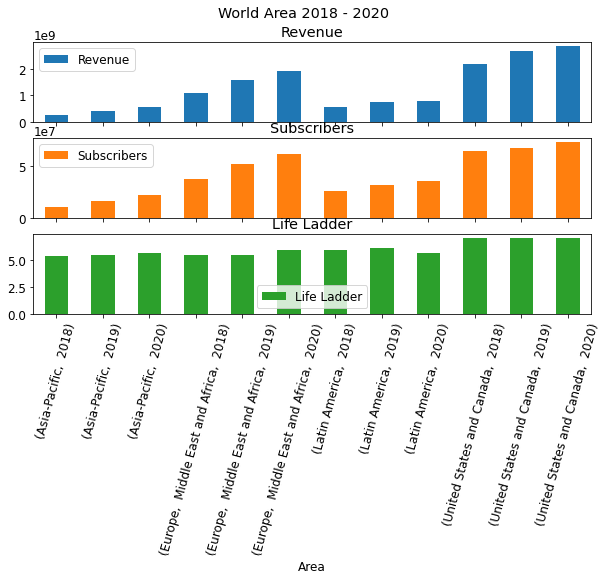

In [51]:
# Bar plot for Netflix vs World Happiness 
netflix_rev_region_year_goupby.plot(kind='bar', title='World Area 2018 - 2020', subplots = True, sharey =False, xlabel='Area', figsize=(10, 5), rot=75)
plt.savefig('Images/Netflix_vs_World Happiness_2018_2020.png',bbox_inches = 'tight')
plt.savefig('Images/Netflix_vs_World Happiness_2018_2020.jpg',bbox_inches = 'tight')
plt.show()

In [52]:
# plt.figure()
# netflix_rev_region_year_goupby.plot.hist(stacked=True, bins=20,figsize=(10, 5))
# plt.show()

# Bar plot

In [53]:
# Bars asia_pacific
def bar_e(x_axis, y_axis):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots()
    sns.barplot(x="Years", y="Revenue", data=asia_pacific,hue="Years",palette=['lightcoral', 'red' ,'darkred'], ax=ax)

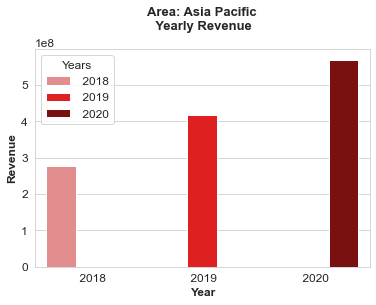

In [54]:
#As a reference
bar_e(asia_pacific['Years'],asia_pacific['Revenue'])
plt.title(f'Area: Asia Pacific\n Yearly Revenue\n', fontsize = 13, fontweight = 'bold')
# plt.savefig('')
# plt.savefig('')
plt.xlabel('Year', fontsize = 12, fontweight = 'bold')
plt.ylabel('Revenue', fontsize = 12,fontweight = 'bold')
plt.show()

In [55]:
# Bars asia_pacific
def bar_d(x_axis, y_axis):
    plt.bar(x_axis, y_axis, alpha = 1, color = ['lightcoral', 'red' ,'darkred'])

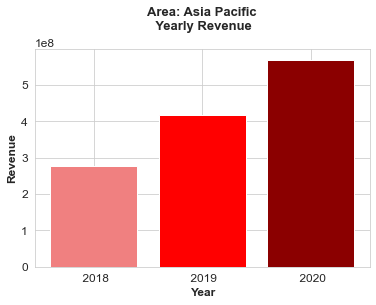

In [56]:
# Asia Pacific\n Yearly Revenue\n
bar_d(asia_pacific['Years'],asia_pacific['Revenue'])
plt.title(f'Area: Asia Pacific\n Yearly Revenue\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Year', fontsize = 12, fontweight = 'bold')
plt.ylabel('Revenue', fontsize = 12,fontweight = 'bold')
plt.savefig('Images/Asia_Pacific_Revenue_2018_2020.png')
plt.savefig('Images/Asia_Pacific_Revenue_2018_2020.jpg')
plt.show()

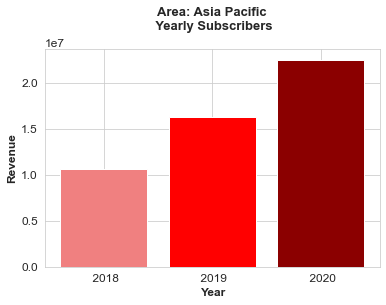

In [57]:
# Asia Pacific\n Yearly Subscribers
bar_d(asia_pacific['Years'],asia_pacific['Subscribers'])
plt.title(f'Area: Asia Pacific\n Yearly Subscribers\n', fontsize = 13, fontweight = 'bold')
year = [2018, 2019, 2020]
plt.xlabel('Year', fontsize = 12, fontweight = 'bold')
plt.ylabel('Revenue', fontsize = 12, fontweight = 'bold')
plt.savefig('Images/Asia_Pacific_Subscribers_2018_2020.png')
plt.savefig('Images/Asia_Pacific_Subscribers_2018_2020.jpg')
plt.show()

In [58]:
# Bars emea
def bar_c(x_axis, y_axis):
    plt.bar(x_axis, y_axis, alpha = 1, color = ['limegreen','forestgreen', 'darkgreen' ])

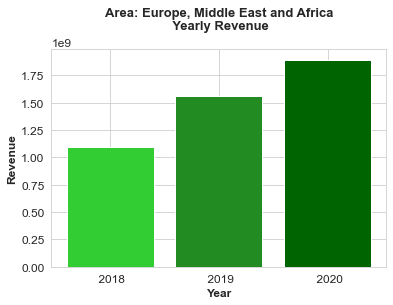

In [59]:
# Europe, Middle East and Africa\n Yearly Revenue
bar_c(emea['Years'],emea['Revenue'])
plt.title(f'Area: Europe, Middle East and Africa\n Yearly Revenue\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Year', fontsize = 12,fontweight = 'bold')
plt.ylabel('Revenue', fontsize = 12,fontweight = 'bold')
plt.savefig('Images/latin_america_Revenue_2018_2020.png')
plt.savefig('Images/latin_america_Revenue_2018_2020.jpg')
plt.show()

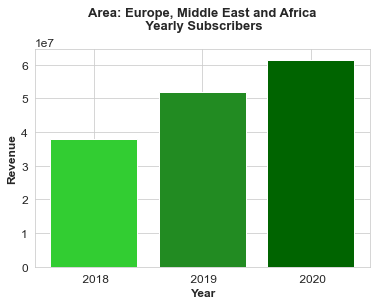

In [60]:
# Europe, Middle East and Africa\n Yearly Subscribers
bar_c(emea['Years'],emea['Subscribers'])
plt.title(f'Area: Europe, Middle East and Africa\n Yearly Subscribers\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Year', fontsize = 12,fontweight = 'bold')
plt.ylabel('Revenue', fontsize = 12,fontweight = 'bold')
plt.savefig('Images/latin_america_Subscribers_2018_2020.png')
plt.savefig('Images/latin_america_Subscribers_2018_2020.jpg')
plt.show()

In [61]:
# Bars latin_america
def bar_b(x_axis, y_axis):
    plt.bar(x_axis, y_axis, alpha = 1, color = ['palegoldenrod', 'gold' ,'darkgoldenrod'])

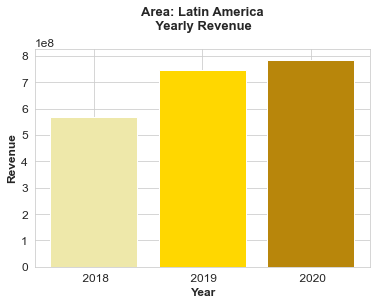

In [62]:
# Latin America\n Yearly Revenue\n
bar_b(latin_america['Years'],latin_america['Revenue'])
plt.title(f'Area: Latin America\n Yearly Revenue\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Year', fontsize = 12,fontweight = 'bold')
plt.ylabel('Revenue', fontsize = 12,fontweight = 'bold')
plt.savefig('Images/latin_america_Revenue_2018_2020.png')
plt.savefig('Images/latin_america_Revenue_2018_2020.jpg')
plt.show()

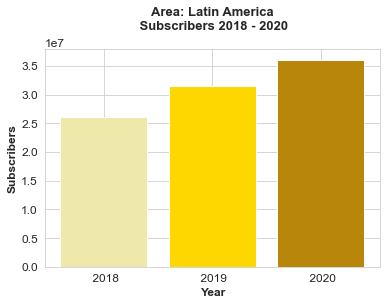

In [63]:
# Latin America\n Subscribers 2018 - 2020
bar_b(latin_america['Years'],latin_america['Subscribers'])
plt.title(f'Area: Latin America\n Subscribers 2018 - 2020\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Year', fontsize = 12,fontweight = 'bold')
plt.ylabel('Subscribers', fontsize = 12,fontweight = 'bold')
plt.savefig('Images/latin_america_Subscribers_2018_2020.png')
plt.savefig('Images/latin_america_Subscribers_2018_2020.jpg')
plt.show()

In [64]:
# Bars usa_area
def bar(x_axis, y_axis):
    plt.bar(x_axis, y_axis, alpha = 1, color = ['powderblue', 'royalblue', 'navy'])

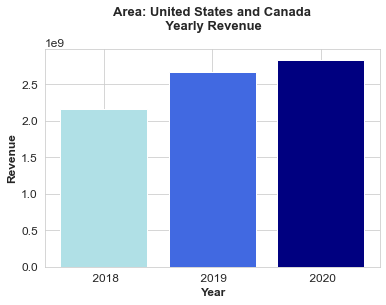

In [65]:
# United States and Canada\n Yearly Revenue\
bar(usa_area['Years'],usa_area['Revenue'])
plt.title(f'Area: United States and Canada\n Yearly Revenue\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Year', fontsize = 12,fontweight = 'bold')
plt.ylabel('Revenue', fontsize = 12,fontweight = 'bold')
plt.savefig('Images/usa_area_Revenue_2018_2020.png')
plt.savefig('Images/usa_area_Revenue_2018_2020.jpg')
plt.show()

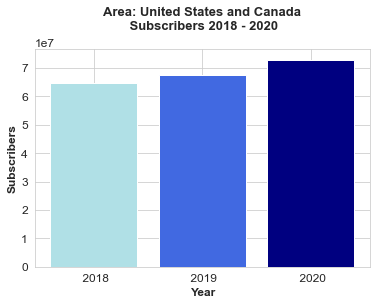

In [66]:
# United States and Canada\n Subscribers 2018 - 2020
bar(usa_area['Years'],usa_area['Subscribers'])
plt.title(f'Area: United States and Canada\n Subscribers 2018 - 2020\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Year', fontsize = 12,fontweight = 'bold')
plt.ylabel('Subscribers', fontsize = 12,fontweight = 'bold')
plt.savefig('Images/usa_area_Subscribers_2018_2020.png')
plt.savefig('Images/usa_area_Subscribers_2018_2020.jpg')
plt.show()


# Scatter plot and linear regression

In [67]:
world_happiness_report

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.842,0.032,7.904,7.780,10.775,0.954,72.000,0.949,-0.098,0.186,2.43,1.446,1.106,0.741,0.691,0.124,0.481,3.253
1,Denmark,Western Europe,7.620,0.035,7.687,7.552,10.933,0.954,72.700,0.946,0.030,0.179,2.43,1.502,1.108,0.763,0.686,0.208,0.485,2.868
2,Switzerland,Western Europe,7.571,0.036,7.643,7.500,11.117,0.942,74.400,0.919,0.025,0.292,2.43,1.566,1.079,0.816,0.653,0.204,0.413,2.839
3,Iceland,Western Europe,7.554,0.059,7.670,7.438,10.878,0.983,73.000,0.955,0.160,0.673,2.43,1.482,1.172,0.772,0.698,0.293,0.170,2.967
4,Netherlands,Western Europe,7.464,0.027,7.518,7.410,10.932,0.942,72.400,0.913,0.175,0.338,2.43,1.501,1.079,0.753,0.647,0.302,0.384,2.798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Lesotho,Sub-Saharan Africa,3.512,0.120,3.748,3.276,7.926,0.787,48.700,0.715,-0.131,0.915,2.43,0.451,0.731,0.007,0.405,0.103,0.015,1.800
145,Botswana,Sub-Saharan Africa,3.467,0.074,3.611,3.322,9.782,0.784,59.269,0.824,-0.246,0.801,2.43,1.099,0.724,0.340,0.539,0.027,0.088,0.648
146,Rwanda,Sub-Saharan Africa,3.415,0.068,3.548,3.282,7.676,0.552,61.400,0.897,0.061,0.167,2.43,0.364,0.202,0.407,0.627,0.227,0.493,1.095
147,Zimbabwe,Sub-Saharan Africa,3.145,0.058,3.259,3.030,7.943,0.750,56.201,0.677,-0.047,0.821,2.43,0.457,0.649,0.243,0.359,0.157,0.075,1.205


The r - square is: 0.62
The correlation is: 0.79
The Standard Error is: 0.05458299680600536


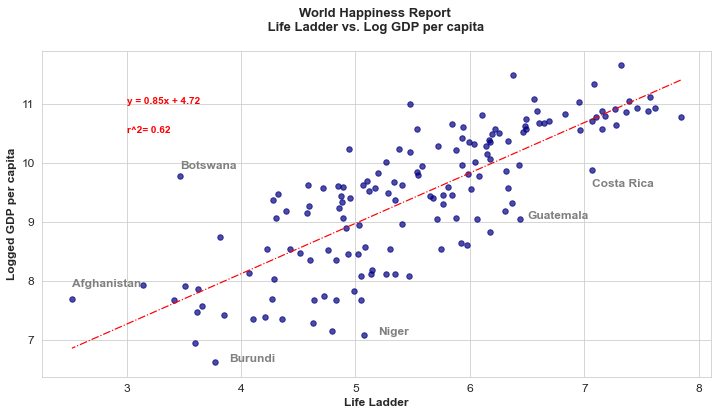

In [68]:
# world_happiness
def linear_regression_g(x_axis, y_axis,x,y):
    corr = round(st.pearsonr(x_axis,y_axis)[0],2)
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
    rv = x_axis * slope + intercept
    le = 'y = ' + str(round(slope,2)) + 'x + ' +str(round(intercept,2))
    fig1,ax1=plt.subplots(figsize=(12,6))
    plt.scatter(x_axis, y_axis, color = 'navy', s = 30, alpha = 0.7)
    plt.plot(x_axis,rv, 'r-.',linewidth =1.2, color = 'red')
    plt.annotate(le,(x,y), fontsize = 10 , color = 'red',fontweight = 'bold')
    plt.annotate(f'r^2= {round(rvalue**2,2)}',(x,y-0.5),fontsize=10,color="red", fontweight='bold')
    print(f'The r - square is: {round(rvalue**2,2)}')
    print(f'The correlation is: {round(corr,2)}')
    print(f'The Standard Error is: {stderr}')
    
linear_regression_g(world_happiness_report['Ladder score'], world_happiness_report ['Logged GDP per capita'],3,11)
plt.title(f'World Happiness Report \n Life Ladder vs. Log GDP per capita \n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Life Ladder', fontsize = 12,fontweight = 'bold')
plt.ylabel('Logged GDP per capita', fontsize = 12,fontweight = 'bold')
plt.annotate(f'Afghanistan',(2.523,7.9), fontsize = 12 , color = 'grey',fontweight = 'bold')
plt.annotate(f'Botswana',(3.467,9.9), fontsize = 12 , color = 'grey',fontweight = 'bold')
plt.annotate(f'Costa Rica',(7.069,9.6), fontsize = 12 , color = 'grey',fontweight = 'bold')
plt.annotate(f'Burundi',(3.9, 6.635), fontsize = 12 , color = 'grey',fontweight = 'bold')
plt.annotate(f'Niger',(5.2, 7.098), fontsize = 12 , color = 'grey',fontweight = 'bold')
plt.annotate(f'Guatemala',(6.5, 9.053), fontsize = 12 , color = 'grey',fontweight = 'bold')

plt.savefig('Images/world_happiness_report_Ladder_vs_GDPpercapita_Linear_Regression.png', bbox_inches = 'tight')
plt.savefig('Images/world_happiness_report_Ladder_vs_GDPpercapita_Linear_Regression.jpg',bbox_inches = 'tight')
plt.show()

In [113]:
# Linear Regression
def linear_regression(x_axis, y_axis,x,y):
    corr = round(st.pearsonr(x_axis,y_axis)[0],2)
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
    rv = x_axis * slope + intercept
    le = 'y = ' + str(round(slope,2)) + 'x + ' +str(round(intercept,2))
    fig1,ax1=plt.subplots(figsize=(10,5))
    plt.scatter(x_axis, y_axis, color = 'navy', s = 30, alpha = 0.8)
    plt.plot(x_axis,rv, 'r-.',linewidth =1.2, color = 'red')
    plt.annotate(le,(x,y), fontsize = 10 , color = 'red',fontweight = 'bold')
    plt.annotate(f'r^2= {round(rvalue**2,2)}',(x,y-0.11e9),fontsize=10,color="red", fontweight='bold')
    print(f'The r - square is: {round(rvalue**2,2)}')
    print(f'The correlation is: {round(corr,2)}')
    print(f'The Standard Error is: {stderr}')

In [114]:
usa_area

,Area,Years,Revenue,Subscribers,Life Ladder
9,United States and Canada,2018,2160979000,64757000,7.0290
10,United States and Canada,2019,2671908000,67662000,7.0265
11,United States and Canada,2020,2839670000,72904000,7.0265


The r - square is: 0.94
The correlation is: -0.97
The Standard Error is: 58114461515.88552


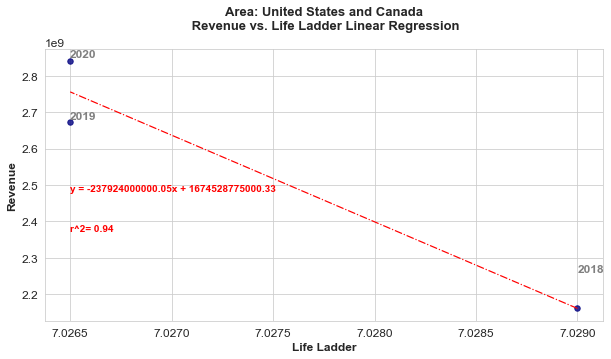

In [115]:
# United States and Canada
linear_regression(usa_area['Life Ladder'],usa_area['Revenue'],7.0265,2481948000)
plt.savefig('Images/USA_Revenue_vs_Life_Ladder_Linear_Regression.png')
plt.savefig('Images/USA_Revenue_vs_Life_Ladder_Linear_Regression.jpg')
plt.title(f'Area: United States and Canada\n Revenue vs. Life Ladder Linear Regression\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Life Ladder', fontsize = 12,fontweight = 'bold')
plt.ylabel('Revenue', fontsize = 12,fontweight = 'bold')
plt.annotate(f'2018',(7.0290,2260979000), fontsize = 12 , color = 'grey',fontweight = 'bold')
plt.annotate(f'2019',(7.0265,2681948000), fontsize = 12 , color = 'grey',fontweight = 'bold')
plt.annotate(f'2020',(7.0265,2849730000), fontsize = 12 , color = 'grey',fontweight = 'bold')
plt.savefig('Images/USA_Revenue_vs_Life_Ladder_Linear_Regression.png')
plt.savefig('Images/USA_Revenue_vs_Life_Ladder_Linear_Regression.jpg')

The r - square is: 0.6
The correlation is: -0.77
The Standard Error is: 1815882066.6555722


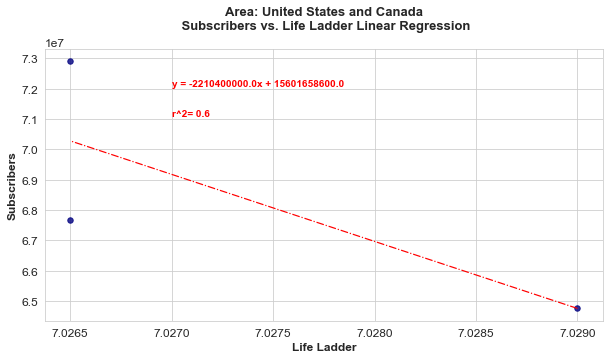

In [166]:
# United States and Canada

# Linear Regression
def linear_regression_usa(x_axis, y_axis,x,y):
    corr = round(st.pearsonr(x_axis,y_axis)[0],2)
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
    rv = x_axis * slope + intercept
    le = 'y = ' + str(round(slope,2)) + 'x + ' +str(round(intercept,2))
    fig1,ax1=plt.subplots(figsize=(10,5))
    plt.scatter(x_axis, y_axis, color = 'navy', s = 30, alpha = 0.8)
    plt.plot(x_axis,rv, 'r-.',linewidth =1.2, color = 'red')
    plt.annotate(le,(x,y), fontsize = 10 , color = 'red',fontweight = 'bold')
    plt.annotate(f'r^2= {round(rvalue**2,2)}',(x,y-0.001e9),fontsize=10,color="red", fontweight='bold')
    print(f'The r - square is: {round(rvalue**2,2)}')
    print(f'The correlation is: {round(corr,2)}')
    print(f'The Standard Error is: {stderr}')

linear_regression_usa(usa_area['Life Ladder'],usa_area['Subscribers'],7.027,7.21e7)
plt.title(f'Area: United States and Canada\n Subscribers vs. Life Ladder Linear Regression\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Life Ladder', fontsize = 12,fontweight = 'bold')
plt.ylabel('Subscribers', fontsize = 12,fontweight = 'bold')
plt.savefig('Images/USA_Subscribers_vs_Life_Ladder_Linear_Regression.png')
plt.savefig('Images/USA_Subscribers_vs_Life_Ladder_Linear_Regression.jpg')
plt.show()

In [167]:
# Linear Regression
def linear_regression_b(x_axis, y_axis,x,y):
    corr = round(st.pearsonr(x_axis,y_axis)[0],2)
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
    rv = x_axis * slope + intercept
    le = 'y = ' + str(round(slope,2)) + 'x + ' +str(round(intercept,2))
    fig1,ax1=plt.subplots(figsize=(10,5))
    plt.scatter(x_axis, y_axis, color = 'navy', s = 30, alpha = 0.8)
    plt.plot(x_axis,rv, 'r-.',linewidth =1.2, color = 'red')
    plt.annotate(le,(x,y), fontsize = 10 , color = 'red',fontweight = 'bold')
    plt.annotate(f'r^2= {round(rvalue**2,2)}',(x,y-0.2e8),fontsize=10,color="red", fontweight='bold')
    print(f'The r - square is: {round(rvalue**2,2)}')
    print(f'The correlation is: {round(corr,2)}')
    print(f'The Standard Error is: {stderr}')

In [168]:
asia_pacific

,Area,Years,Revenue,Subscribers,Life Ladder
0,Asia-Pacific,2018,276756000,10607000,5.335806
1,Asia-Pacific,2019,418121000,16233000,5.423774
2,Asia-Pacific,2020,569140000,22492000,5.663632


The r - square is: 0.94
The correlation is: 0.97
The Standard Error is: 206781969.50446662


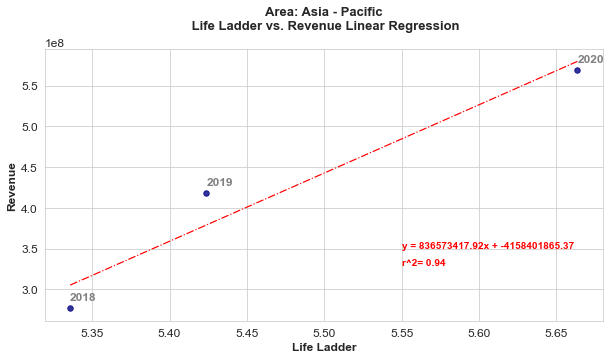

In [128]:
# asia_pacific
linear_regression_b(asia_pacific['Life Ladder'], asia_pacific['Revenue'],5.55, 3.5e8)
plt.title(f'Area: Asia - Pacific\n Life Ladder vs. Revenue Linear Regression\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Life Ladder', fontsize = 12,fontweight = 'bold')
plt.ylabel('Revenue', fontsize = 12,fontweight = 'bold')
plt.annotate(f'2018',(5.335806,286756000), fontsize = 12 , color = 'grey',fontweight = 'bold')
plt.annotate(f'2019',(5.423774,428121000), fontsize = 12 , color = 'grey',fontweight = 'bold')
plt.annotate(f'2020',(5.663632,579140000), fontsize = 12 , color = 'grey',fontweight = 'bold')
plt.savefig('Images/Asia_Pacific_Revenue_vs__Linear_Regression.png')
plt.savefig('Images/Asia_Pacific_Revenue_vs_Life_Ladder_Linear_Regression.jpg')
plt.show()

The r - square is: 0.95
The correlation is: 0.97
The Standard Error is: 8009996.622678351


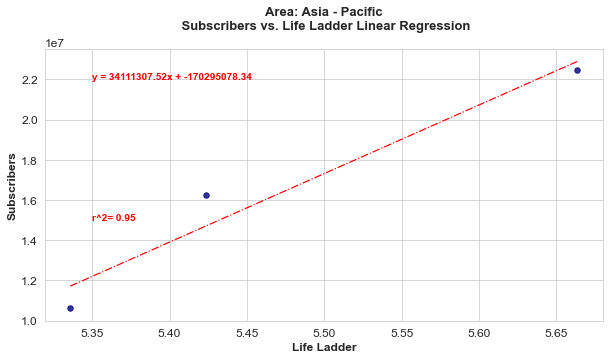

In [142]:
# Linear Regression
def linear_regression_bc(x_axis, y_axis,x,y):
    corr = round(st.pearsonr(x_axis,y_axis)[0],2)
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
    rv = x_axis * slope + intercept
    le = 'y = ' + str(round(slope,2)) + 'x + ' +str(round(intercept,2))
    fig1,ax1=plt.subplots(figsize=(10,5))
    plt.scatter(x_axis, y_axis, color = 'navy', s = 30, alpha = 0.8)
    plt.plot(x_axis,rv, 'r-.',linewidth =1.2, color = 'red')
    plt.annotate(le,(x,y), fontsize = 10 , color = 'red',fontweight = 'bold')
    plt.annotate(f'r^2= {round(rvalue**2,2)}',(x,y-0.07e8),fontsize=10,color="red", fontweight='bold')
    print(f'The r - square is: {round(rvalue**2,2)}')
    print(f'The correlation is: {round(corr,2)}')
    print(f'The Standard Error is: {stderr}')

# asia_pacific
linear_regression_bc(asia_pacific['Life Ladder'],asia_pacific['Subscribers'], 5.35,2.2e7)
plt.title(f'Area: Asia - Pacific\n Subscribers vs. Life Ladder Linear Regression\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Life Ladder', fontsize = 12,fontweight = 'bold')
plt.ylabel('Subscribers', fontsize = 12,fontweight = 'bold')
plt.savefig('Images/Asia_Pacific_Subscribers_vs_Life_Ladder_Linear_Regression.png')
plt.savefig('Images/Asia_Pacific_Subscribers_vs_Life_Ladder_Linear_Regression.jpg')
plt.show()

In [145]:
latin_america

,Area,Years,Revenue,Subscribers,Life Ladder
6,Latin America,2018,567137000,26077000,5.951167
7,Latin America,2019,746392000,31417000,6.117579
8,Latin America,2020,785368000,36068000,5.660182


The r - square is: 0.1
The correlation is: -0.32
The Standard Error is: 476545749.7174306


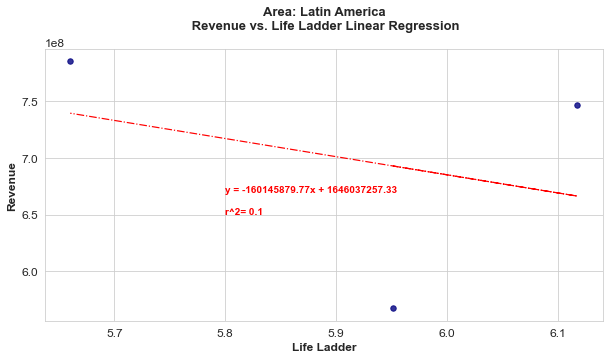

In [146]:
# Latin America\n Revenue vs. Life Ladder Linear Regression
linear_regression_b(latin_america['Life Ladder'],latin_america['Revenue'],5.8,6.7e8)
plt.title(f'Area: Latin America\n Revenue vs. Life Ladder Linear Regression\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Life Ladder', fontsize = 12,fontweight = 'bold')
plt.ylabel('Revenue', fontsize = 12,fontweight = 'bold')
plt.savefig('Images/Latin_America_Revenue_vs_Life_Ladder_Linear_Regression.png')
plt.savefig('Images/Latin_America_Revenue_vs_Life_Ladder_Linear_Regression.jpg')
plt.show()

The r - square is: 0.36
The correlation is: -0.6
The Standard Error is: 17324331.117138073


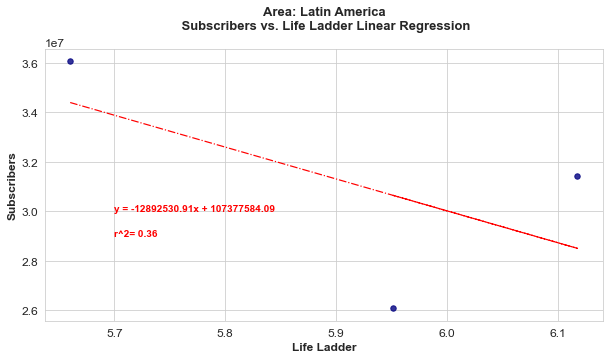

In [157]:
# Linear Regression
def linear_regression_be(x_axis, y_axis,x,y):
    corr = round(st.pearsonr(x_axis,y_axis)[0],2)
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
    rv = x_axis * slope + intercept
    le = 'y = ' + str(round(slope,2)) + 'x + ' +str(round(intercept,2))
    fig1,ax1=plt.subplots(figsize=(10,5))
    plt.scatter(x_axis, y_axis, color = 'navy', s = 30, alpha = 0.8)
    plt.plot(x_axis,rv, 'r-.',linewidth =1.2, color = 'red')
    plt.annotate(le,(x,y), fontsize = 10 , color = 'red',fontweight = 'bold')
    plt.annotate(f'r^2= {round(rvalue**2,2)}',(x,y-0.01e8),fontsize=10,color="red", fontweight='bold')
    print(f'The r - square is: {round(rvalue**2,2)}')
    print(f'The correlation is: {round(corr,2)}')
    print(f'The Standard Error is: {stderr}')

linear_regression_be(latin_america['Life Ladder'],latin_america['Subscribers'],5.7,3.0e7)
plt.title(f'Area: Latin America\n Subscribers vs. Life Ladder Linear Regression\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Life Ladder', fontsize = 12,fontweight = 'bold')
plt.ylabel('Subscribers', fontsize = 12,fontweight = 'bold')
plt.savefig('Images/Latin_America_Subscribers_vs_Life_Ladder_Linear_Regression.png')
plt.savefig('Images/Latin_America_Subscribers_vs_Life_Ladder_Linear_Regression.jpg')
plt.show()

The r - square is: 0.74
The correlation is: 0.86
The Standard Error is: 810597986.1874372


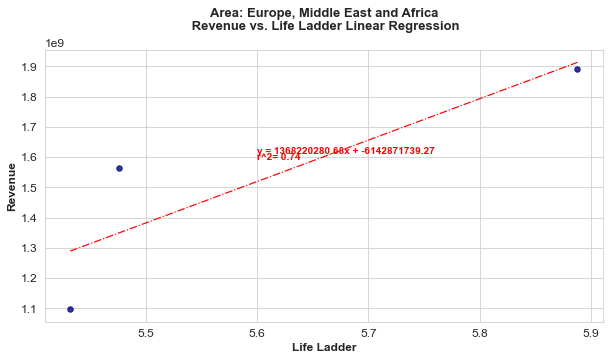

In [159]:
#emea
linear_regression_b(emea['Life Ladder'],emea['Revenue'],5.6,1.61e9)
plt.title(f'Area: Europe, Middle East and Africa\n Revenue vs. Life Ladder Linear Regression\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Life Ladder', fontsize = 12,fontweight = 'bold')
plt.ylabel('Revenue', fontsize = 12,fontweight = 'bold')
plt.savefig('Images/EMEA_Revenue_vs_Life_Ladder_Linear_Regression.png')
plt.savefig('Images/EMEA_Revenue_vs_Life_Ladder_Linear_Regression.jpg')
plt.show()

In [160]:
emea

,Area,Years,Revenue,Subscribers,Life Ladder
3,"Europe, Middle East and Africa",2018,1096812000,37818000,5.432220
4,"Europe, Middle East and Africa",2019,1562561000,51778000,5.475880
5,"Europe, Middle East and Africa",2020,1892537000,61483000,5.887825


The r - square is: 0.74
The correlation is: 0.86
The Standard Error is: 24333220.54946584


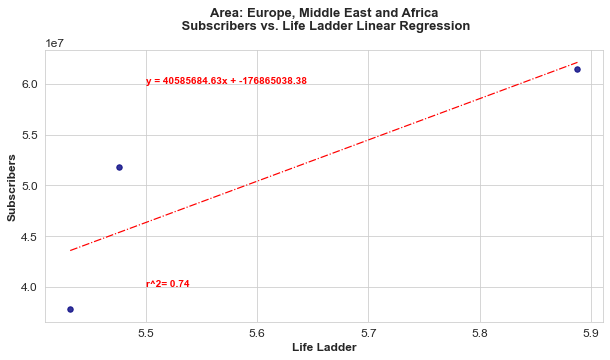

In [165]:
linear_regression_b(emea['Life Ladder'],emea['Subscribers'],5.5, 6.0e7)
plt.savefig('Images/EMEA_Subscribers_vs_Life_Ladder_Linear_Regression.png')
plt.savefig('Images/EMEA_Subscribers_vs_Life_Ladder_Linear_Regression.jpg')
plt.title(f'Area: Europe, Middle East and Africa\n Subscribers vs. Life Ladder Linear Regression\n', fontsize = 13, fontweight = 'bold')
plt.xlabel('Life Ladder', fontsize = 12,fontweight = 'bold')
plt.ylabel('Subscribers', fontsize = 12,fontweight = 'bold')
plt.show()

In [77]:
# Count number of titles in each country
title_count = df.groupby(['Country']).count()
title_count

,Title,Genre,Languages,Director,Media Type
Country,,,,,
Argentina,5138,4812,4644,3278,5138
Australia,5820,5388,5200,3672,5820
Belgium,5437,5062,4906,3448,5437
Brazil,5057,4709,4551,3189,5057
Canada,5930,5510,5326,3853,5930
Colombia,4867,4560,4401,3051,4867
Czech Republic,6237,5706,5537,4047,6237
France,5194,4821,4668,3223,5194
Germany,5539,5101,4942,3489,5539


In [78]:
# Break out each genre into a separate row
netflix_genre_split = df.Genre.str.split(',')
genre_series = netflix_genre_split.apply(pd.Series, 1)
genre_stacked = genre_series.stack()
drop = genre_stacked.index = genre_stacked.index.droplevel(-1)
genre_df = pd.DataFrame(genre_stacked)
genre_df = genre_df.join(df)
del genre_df['Title']
del genre_df['Director']
del genre_df['Genre']
del genre_df['Media Type']
genre_df.columns = ['Genre','Country','Languages']
genre_df = genre_df.reset_index(drop=True)
# df.to_csv('Netflix_by_Country.csv', index = False)
genre_df

,Genre,Country,Languages
0,Crime,Thailand,"Swedish, Spanish"
1,Drama,Thailand,"Swedish, Spanish"
2,Fantasy,Thailand,"Swedish, Spanish"
3,Horror,Thailand,"Swedish, Spanish"
4,Romance,Thailand,"Swedish, Spanish"
...,...,...,...
454057,Family,Israel,English
454058,Animation,Colombia,English
454059,Action,Colombia,English
454060,Comedy,Colombia,English


In [79]:
# Use describe to check the top genre in each country
genre_df.groupby(['Country']).describe()

Genre                      Languages                      
                count unique     top  freq     count unique      top  freq
Country                                                                   
Argentina       12234     52   Drama  1277     11865    554  English  5246
Australia       13294     53   Drama  1399     12896    605  English  5731
Belgium         13085     52   Drama  1382     12728    615  English  5601
Brazil          11935     51   Drama  1234     11576    541  English  5119
Canada          13687     52   Drama  1451     13292    623  English  5963
Colombia        11882     52   Drama  1271     11524    550  English  5003
Czech Republic  14057     53   Drama  1523     13682    674  English  5715
France          12339     52   Drama  1276     11997    576  English  5154
Germany         13050     52   Drama  1411     12693    622  English  5304
Greece          12033     52  Comedy  1298     11683    584  English  4895
Hong Kong       12367     52   Drama  1293     12028    580  English  5105
Hungary         13595     52   Drama  1463     13218    655  English  5564
Iceland         11889     52   Drama  1283     11522    542  English  4737
India           13245     52   Drama  1440     12855    603  English  5227
Israel          11884     52  Comedy  1268     11528    545  English  4795
Italy           12225     52   Drama  1311     11881    584  English  5175
Japan           14404     51   Drama  1480     14044    601  English  4955
Lithuania       12264     52  Comedy  1370     11891    571  English  4888
Malaysia        12693     53   Drama  1352     12332    589  English  4785
Mexico          12232     52   Drama  1273     11863    549  English  5261
Netherlands     11903     52   Drama  1263     11559    565  English  5163
Poland          11930     52  Comedy  1250     11588    573  English  5254
Portugal        11058     52   Drama  1147     10727    507  English  4753
Romania         13168     52   Drama  1429     12807    643  English  5440
Russia          12225     52  Comedy  1344     11858    558  English  4818
Singapore       13475     53   Drama  1419     13102    624  English  5192
Slovakia        13185     53   Drama  1447     12814    631  English  5332
South Africa    12452     53  Comedy  1365     12071    568  English  5116
South Korea     11894     51   Drama  1226     11563    573  English  4929
Spain           11791     52   Drama  1223     11450    550  English  4947
Sweden          11374     52   Drama  1191     11036    537  English  4998
Switzerland     13191     52   Drama  1384     12846    618  English  5561
Thailand        13478     52   Drama  1408     13101    607  English  5185
Turkey          11435     52   Drama  1193     11099    537  English  4979
United Kingdom  14329     53  Comedy  1556     13928    632  English  6225
United States   12780     52   Drama  1357     12375    540  English  5615

In [80]:
# Build dataframes with counts for each genre

In [81]:
horror_df = genre_df.loc[genre_df["Genre"]=="Horror"]
horror_count = horror_df.groupby(['Country']).count()

In [82]:
comedy_df = genre_df.loc[genre_df["Genre"]=="Comedy"]
comedy_count = comedy_df.groupby(['Country']).count()

In [83]:
doc_df = genre_df.loc[genre_df["Genre"]=="Documentary"]
doc_count = doc_df.groupby(['Country']).count()

In [84]:
drama_df = genre_df.loc[genre_df["Genre"]=="Drama"]
drama_count = drama_df.groupby(['Country']).count()

In [85]:
romance_df = genre_df.loc[genre_df["Genre"]=="Romance"]
romance_count = romance_df.groupby(['Country']).count()

In [86]:
# Construct main dataframe with genre count and percent by country
total_horror_df = pd.merge(title_count,horror_count,how='outer',on='Country',suffixes=("_Total","_Horror"))
del total_horror_df["Languages_Total"]
del total_horror_df['Director']
del total_horror_df['Languages_Horror']
del total_horror_df['Media Type']
horror_comedy_df = pd.merge(total_horror_df,comedy_count,how='outer',on='Country')
del horror_comedy_df["Languages"]
horror_comedy_df.columns = ['Title_Count','Genre_Count','Horror_Count','Comedy_Count']
del horror_comedy_df["Genre_Count"]
horror_percent = horror_comedy_df['Horror_Count']/horror_comedy_df['Title_Count']*100
horror_comedy_df["Horror_Percent"] = round(horror_percent,2)
comedy_percent = horror_comedy_df['Comedy_Count']/horror_comedy_df['Title_Count']*100
horror_comedy_df["Comedy_Percent"] = round(comedy_percent,2)

In [87]:
# Continue merging into dataframe containing the genre data
genre_data_df1 = pd.merge(horror_comedy_df,doc_count,how='outer',on='Country')
del genre_data_df1["Languages"]
genre_data_df1.columns = ['Title_Count','Horror_Count','Comedy_Count','Horror_Percent','Comedy_Percent','Doc_Count']
doc_percent = genre_data_df1['Doc_Count']/genre_data_df1['Title_Count']*100
genre_data_df1["Doc_Percent"] = round(doc_percent,2)

# More merging into main dataframe
genre_data_df2 = pd.merge(genre_data_df1,drama_count,how='outer',on='Country')
del genre_data_df2['Languages']
genre_data_df = pd.merge(genre_data_df2,romance_count,how='outer',on='Country')
del genre_data_df['Languages']
genre_data_df.columns = ['Title_Count','Horror_Count','Comedy_Count','Horror_Percent','Comedy_Percent','Doc_Count','Doc_Percent','Drama_Count','Romance_Count']
drama_percent = genre_data_df['Drama_Count']/genre_data_df['Title_Count']*100
genre_data_df["Drama_Percent"] = round(drama_percent,2)
romance_percent = genre_data_df['Romance_Count']/genre_data_df['Title_Count']*100
genre_data_df["Romance_Percent"] = round(romance_percent,2)

genre_data_df

,Title_Count,Horror_Count,Comedy_Count,Horror_Percent,Comedy_Percent,Doc_Count,Doc_Percent,Drama_Count,Romance_Count,Drama_Percent,Romance_Percent
Country,,,,,,,,,,,
Argentina,5138,93,1222,1.81,23.78,598,11.64,791,31,15.40,0.60
Australia,5820,102,1377,1.75,23.66,643,11.05,951,57,16.34,0.98
Belgium,5437,90,1299,1.66,23.89,585,10.76,795,28,14.62,0.51
Brazil,5057,93,1174,1.84,23.22,589,11.65,781,31,15.44,0.61
Canada,5930,111,1376,1.87,23.20,660,11.13,954,47,16.09,0.79
Colombia,4867,93,1045,1.91,21.47,557,11.44,785,31,16.13,0.64
Czech Republic,6237,111,1522,1.78,24.40,651,10.44,1011,57,16.21,0.91
France,5194,81,1250,1.56,24.07,576,11.09,798,25,15.36,0.48
Germany,5539,101,1335,1.82,24.10,587,10.60,818,34,14.77,0.61


In [88]:
# Load in happiness data 
file_to_load_h = 'Data Sets/World Happiness Report/world-happiness-report-2021.csv'
world_happiness_report = pd.read_csv(file_to_load_h)

In [89]:
# Clean world happiness report data
world_happiness_report.head()
world_happiness_report_sub = world_happiness_report[['Country name','Regional indicator','Ladder score']]
world_happiness_report_sub.columns = ['Country','Region','Ladder Score']
world_happiness_report_sub

,Country,Region,Ladder Score
0,Finland,Western Europe,7.842
1,Denmark,Western Europe,7.620
2,Switzerland,Western Europe,7.571
3,Iceland,Western Europe,7.554
4,Netherlands,Western Europe,7.464
...,...,...,...
144,Lesotho,Sub-Saharan Africa,3.512
145,Botswana,Sub-Saharan Africa,3.467
146,Rwanda,Sub-Saharan Africa,3.415
147,Zimbabwe,Sub-Saharan Africa,3.145


In [90]:
# Merge in happiness data and clean dataframe
happiness_genre_df = pd.merge(genre_data_df,world_happiness_report_sub,how='left',on='Country')
del happiness_genre_df['Region']
happiness_genre_df.dropna(inplace=True)
happiness_genre_df

,Country,Title_Count,Horror_Count,Comedy_Count,Horror_Percent,Comedy_Percent,Doc_Count,Doc_Percent,Drama_Count,Romance_Count,Drama_Percent,Romance_Percent,Ladder Score
0,Argentina,5138,93,1222,1.81,23.78,598,11.64,791,31,15.40,0.60,5.929
1,Australia,5820,102,1377,1.75,23.66,643,11.05,951,57,16.34,0.98,7.183
2,Belgium,5437,90,1299,1.66,23.89,585,10.76,795,28,14.62,0.51,6.834
3,Brazil,5057,93,1174,1.84,23.22,589,11.65,781,31,15.44,0.61,6.330
4,Canada,5930,111,1376,1.87,23.20,660,11.13,954,47,16.09,0.79,7.103
5,Colombia,4867,93,1045,1.91,21.47,557,11.44,785,31,16.13,0.64,6.012
6,Czech Republic,6237,111,1522,1.78,24.40,651,10.44,1011,57,16.21,0.91,6.965
7,France,5194,81,1250,1.56,24.07,576,11.09,798,25,15.36,0.48,6.690
8,Germany,5539,101,1335,1.82,24.10,587,10.60,818,34,14.77,0.61,7.155
9,Greece,5324,95,1298,1.78,24.38,599,11.25,891,52,16.74,0.98,5.723


In [91]:
import matplotlib.pyplot as plt

Text(3.9, 23.8, 'India')

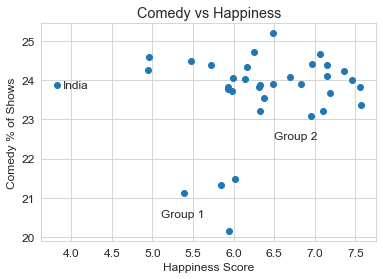

In [92]:
# Build initial comedy vs happiness plot
plt.scatter(happiness_genre_df["Ladder Score"],happiness_genre_df["Comedy_Percent"])
plt.xlabel("Happiness Score")
plt.ylabel("Comedy % of Shows")
plt.title("Comedy vs Happiness")
plt.annotate("Group 2",(6.5,22.5))
plt.annotate("Group 1",(5.1,20.5))
plt.annotate("India",(3.9,23.8))

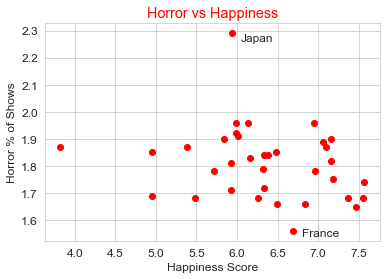

In [93]:
# Build horror vs happiness plot
plt.scatter(happiness_genre_df["Ladder Score"],happiness_genre_df["Horror_Percent"],color="red")
plt.xlabel("Happiness Score")
plt.ylabel("Horror % of Shows")
plt.title("Horror vs Happiness",color="red")
plt.annotate("Japan",(6.05,2.26))
plt.annotate("France",(6.8,1.54))

plt.savefig("Images/horror_vs_happy.png")

In [94]:
# Separate out the four counties of group 1
group_1 = happiness_genre_df.loc[happiness_genre_df['Comedy_Percent']<22]
group_1_avg = group_1["Ladder Score"].mean()
group_1_avg
group_1

,Country,Title_Count,Horror_Count,Comedy_Count,Horror_Percent,Comedy_Percent,Doc_Count,Doc_Percent,Drama_Count,Romance_Count,Drama_Percent,Romance_Percent,Ladder Score
5,Colombia,4867,93,1045,1.91,21.47,557,11.44,785,31,16.13,0.64,6.012
16,Japan,6115,140,1233,2.29,20.16,565,9.24,950,43,15.54,0.70,5.940
18,Malaysia,5394,101,1139,1.87,21.12,531,9.84,909,47,16.85,0.87,5.384
28,South Korea,4845,92,1034,1.90,21.34,517,10.67,794,30,16.39,0.62,5.845


In [95]:
# Separate the countries in group 2
group_2_india = happiness_genre_df.loc[happiness_genre_df['Comedy_Percent']>22]
group_2 = group_2_india.loc[group_2_india['Ladder Score']>4]
group_2_avg = group_2["Ladder Score"].mean()
group_2_avg

6.496099999999999

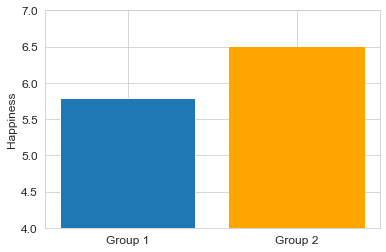

In [96]:
# Build bar graph comparing happiness of group 1 and 2
x_axis = np.arange(0,2,1)
plt.bar(x_axis,[group_1_avg,group_2_avg])[1].set_color('orange')
tick_loc = x_axis
labels = ["Group 1","Group 2"]
plt.xticks(tick_loc,labels)
plt.ylim(4,7)
plt.ylabel("Happiness")

plt.savefig("Images/comedy_vs_happy_bar.png")

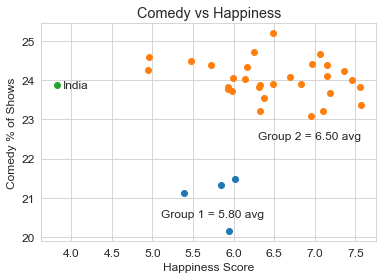

In [97]:
# Build updated comedy vs happiness scatter plot
plt.scatter(group_1["Ladder Score"],group_1["Comedy_Percent"])
plt.scatter(group_2["Ladder Score"],group_2["Comedy_Percent"])
plt.scatter(3.819,23.88)

plt.xlabel("Happiness Score")
plt.ylabel("Comedy % of Shows")
plt.title("Comedy vs Happiness")

plt.annotate("Group 2 = 6.50 avg",(6.3,22.5))
plt.annotate("Group 1 = 5.80 avg",(5.1,20.5))
plt.annotate("India",(3.9,23.8))

plt.savefig("Images/comedy_vs_happy.png")

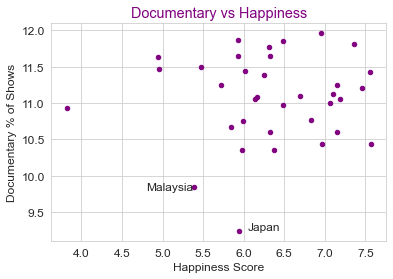

In [98]:
# Build doc vs happiness scatter plot
happiness_genre_df.plot(kind="scatter",x="Ladder Score",y="Doc_Percent",color="purple")
plt.xlabel("Happiness Score")
plt.ylabel("Documentary % of Shows")
plt.title("Documentary vs Happiness",color="purple")
plt.annotate("Japan",(6.05,9.25))
plt.annotate("Malaysia",(4.8,9.8))


# x=happiness_genre_df["Ladder Score"]
# y=happiness_genre_df['Doc_Percent']
# from scipy.stats import linregress
# (slope,intercept,rvalue,pvalue,stderr) = linregress(x,y)
# regress_values = slope*x+intercept
# plt.plot(x,regress_values,color="red")
# plt.annotate(f"y = {round(slope,2)}x + {round(intercept,1)}",(4.2,10.8),color="red")
# print(f"R^2 value is {round(rvalue**2,4)}")

plt.savefig("Images/doc_vs_happy.png")

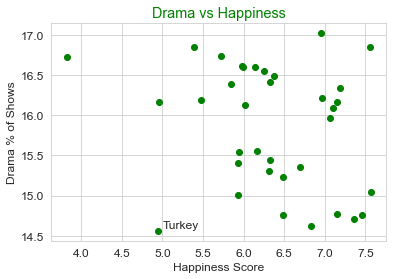

In [99]:
# Build drama vs happiness plot
plt.scatter(happiness_genre_df["Ladder Score"],happiness_genre_df["Drama_Percent"],color="green")
plt.xlabel("Happiness Score")
plt.ylabel("Drama % of Shows")
plt.title("Drama vs Happiness",color="green")
plt.annotate("Turkey",(5,14.6))
# plt.annotate("France",(6.8,1.54))

plt.savefig("Images/drama_vs_happy.png")

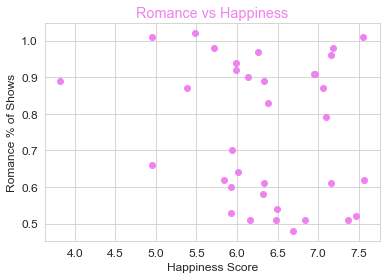

In [100]:
# Build romance vs happiness plot
plt.scatter(happiness_genre_df["Ladder Score"],happiness_genre_df["Romance_Percent"],color="violet")
plt.xlabel("Happiness Score")
plt.ylabel("Romance % of Shows")
plt.title("Romance vs Happiness",color="violet")

plt.savefig("Images/romance_vs_happy.png")